In [567]:
# import
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import line_profiler

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

# from utils.image_utils import (
#     get_images, save_image, plot_side_by_side, gray_scale
# )
# from PIL import Image
import time
import random as random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# %load_ext line_profiler

# torch.set_num_threads(2)

# constants
IMG_SIZE = 32
NUM_CHANNELS = 3

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Data

In [568]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # 0-255 to 0-1
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    # mean and std dev
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [569]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, 
                                        download=True, 
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False, 
                                       download=True, 
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=100, 
                                         shuffle=False, 
                                         num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [565]:
def get_non_car_idx(labels, how_many = 5000):
    non_car_idx = np.where(labels != 1)[0] 
    non_car_idx = np.random.choice(non_car_idx, how_many, replace=False)
    return non_car_idx

labels = np.array(trainset.train_labels)
non_car_idx = get_non_car_idx(labels)
non_cars = trainset.train_data[get_non_car_idx(labels)]

car_idx = np.where(labels == 1)[0]
cars = trainset.train_data[car_idx]

car_labels = np.ones(cars.shape[0])
non_car_labels = np.zeros(cars.shape[0])
combined_data = np.concatenate([cars, non_cars])
combined_data = combined_data / 255.
combined_target = np.concatenate([car_labels, non_car_labels])

balanced_train = torch.utils.data.TensorDataset(torch.from_numpy(combined_data), 
                                                torch.from_numpy(combined_target).long())
print(balanced_train.data_tensor.size())
print(balanced_train.target_tensor.sum())

torch.Size([10000, 32, 32, 3])
5000


In [430]:
# torch_cars = torch.from_numpy(cars).contiguous().float()
# print(torch_cars.size())#.view(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
# torch_cars = torch_cars.view(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
net.eval()
net(torch.from_numpy(testset.test_data[106].reshape(1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)).float())

TypeError: argument 0 is not a Variable

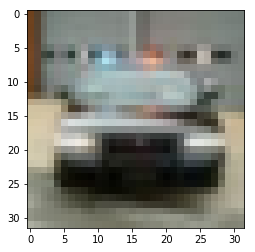

0


In [383]:
plt.imshow(testset.test_data[66])
plt.show()
print(testset.test_labels[65])

In [561]:
net.eval()

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False, 
                                       download=True, 
                                       transform=transform_test)

ones = 0
cars_misclassified = 0
thinks_cars = 0
ships = 0
trucks = 0
for i in range(testset.test_data.shape[0]):
    boom = net(Variable(torch.from_numpy(testset.test_data[i].reshape(1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)).float()))
    if boom.data.tolist()[0][0] > 0.5:
        thinks_cars += 1
    if boom.data.tolist()[0][0] > 0.5 and testset.test_labels[i] == 1:
        ones += 1
    if boom.data.tolist()[0][0] <= 0.5 and testset.test_labels[i] == 1:
        cars_misclassified += 1
    if boom.data.tolist()[0][0] > 0.5 and testset.test_labels[i] == 8:
        ships += 1
    if boom.data.tolist()[0][0] > 0.5 and testset.test_labels[i] == 9: 
        trucks += 1

print("Thinks are cars: ", thinks_cars)
print("Correctly classified cars", ones)
print("Cars misclassified", cars_misclassified)
print("thinks ships are cars", ships)
print("thinks trucks are cars", trucks)
print(testset.test_data.shape[0])

net.train()


Files already downloaded and verified
Thinks are cars:  2197
Correctly classified cars 705
Cars misclassified 295
thinks ships are cars 238
thinks trucks are cars 524
10000


Net(
  (drop1): Dropout2d(p=0.2)
  (drop2): Dropout2d(p=0.3)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=150, bias=True)
  (fc1_drop): Dropout2d(p=0.3)
  (fc2): Linear(in_features=150, out_features=20, bias=True)
  (fc2_drop): Dropout2d(p=0.3)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

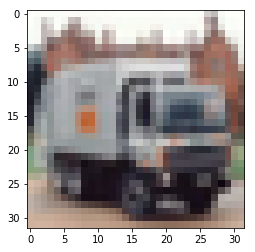

In [91]:
plt.imshow(testset.test_data[11])
plt.show()

In [420]:
test_labels = np.array(testset.test_labels)
non_car_idx = np.where(test_labels != 1)[0]

test_labels[non_car_idx] = 0
testset.test_labels = test_labels.tolist()
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=100, 
                                         shuffle=False, 
                                         num_workers=2)

In [566]:
trainloader = torch.utils.data.DataLoader(balanced_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=2)

In [581]:
# classes = ('not_car', 'car')
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
class StableBCELoss(nn.modules.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()
    def forward(self, inp, target):
        neg_abs = -inp.abs()
        loss = inp.clamp(0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()

### Model

In [599]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop1 = nn.Dropout2d(p = 0.2)
        self.drop2 = nn.Dropout2d(p = 0.3)
        self.conv1 = nn.Conv2d(3, 64, 3, padding=(1, 1))
        self.conv_bnorm = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=(1, 1))
        self.avg_pool = nn.AvgPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 92, 3, padding=(1, 1))
        self.conv4 = nn.Conv2d(92, 92, 3, padding=(1, 1))
#         self.conv4 = nn.Conv2d(64, 64, 3, padding=(1, 1))
        self.max_pool = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(64, 64, 3, padding=(1, 1))
        self.fc1 = nn.Linear(92*8*8, 150)
        self.fc1_drop = nn.Dropout2d(p = 0.3)
        self.fc2 = nn.Linear(150, 10)
#         self.fc2_drop = nn.Dropout2d(p = 0.3)
#         self.fc3 = nn.Linear(20, 1)
#         self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop2(self.max_pool(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = self.drop2(self.max_pool(F.relu(self.conv4(x))))
#         x = self.max_pool(F.relu(self.conv4(x)))
#         x = F.relu(self.conv5(x))
        x = x.view(-1, 92*8*8)
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
net = Net()
# optimizer = optim.SGD(net.parameters(), lr=1, momentum=0.9, weight_decay=0.001)
optimizer = optim.Adam(net.parameters())
# criterion = torch.nn.BCELoss()
criterion = torch.nn.CrossEntropyLoss()

In [472]:
torch.save(net.state_dict(), '/Users/vwr/car autoencoder/pytorch/05.01.19.model')

In [ ]:
print(net.parameters())

In [ ]:
data.size()[0]

In [600]:
def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(trainloader):
#         test()
        target = target
        data = data.float()
        data = data.view(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
        target = target.view(-1, 1)
        data, target = Variable(data, requires_grad=True), Variable(target)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output.float(), target.view(-1))
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))
    
def test():
    net.eval()
    test_loss = 0
    correct = 0
    test_correct = 0
    i = 0
    for batch_idx, (data, target) in enumerate(testloader):
        target = target.float()
        data = data.float()
        data = data.view(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
        data, target = Variable(data, volatile=True), Variable(target)
        pred = net(data)
        test_loss += F.binary_cross_entropy(pred, target) # sum up batch loss
        pred = torch.max(pred.data, 1)
        pred[pred >= 0.5] = 1.0
        pred[pred <= 0.5] = 0.0
        correct += np.sum(np.equal(pred, target.data.numpy().reshape(-1, 1)))#.long().cpu().sum()
        i += 1
    test_loss /= len(testloader.dataset) # average test loss
    print('test_loss', test_loss.data[0])
    print('Accuracy: ' + str(correct/len(testloader.dataset)))
    
def test_softmax():
    net.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
for epoch in range(1, 30):
    train(epoch)
    test_softmax()
net.eval()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306051
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.251815
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.196527
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.079760
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.093032
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.983838
Train Epoch: 1 [15360/50000 (31%)]	Loss: 2.090075
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.930832
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.943973
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.850795
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.895247
Train Epoch: 1 [28160/50000 (56%)]	Loss: 1.795899
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.774258
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.790136
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.724855
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.769317
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.668053
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.687242
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.786659
Train Epoch: 1 [48640/50000 (97%)]	Loss: 1.574183
Accuracy 

Train Epoch: 7 [40960/50000 (82%)]	Loss: 1.174896
Train Epoch: 7 [43520/50000 (87%)]	Loss: 1.134589
Train Epoch: 7 [46080/50000 (92%)]	Loss: 1.086215
Train Epoch: 7 [48640/50000 (97%)]	Loss: 1.235634
Accuracy of plane : 81 %
Accuracy of   car : 75 %
Accuracy of  bird : 28 %
Accuracy of   cat : 46 %
Accuracy of  deer : 61 %
Accuracy of   dog : 68 %
Accuracy of  frog : 81 %
Accuracy of horse : 81 %
Accuracy of  ship : 85 %
Accuracy of truck : 79 %
Train Epoch: 8 [0/50000 (0%)]	Loss: 1.228927
Train Epoch: 8 [2560/50000 (5%)]	Loss: 1.138219
Train Epoch: 8 [5120/50000 (10%)]	Loss: 1.136930
Train Epoch: 8 [7680/50000 (15%)]	Loss: 1.123154
Train Epoch: 8 [10240/50000 (20%)]	Loss: 1.125634
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.156887
Train Epoch: 8 [15360/50000 (31%)]	Loss: 1.143413
Train Epoch: 8 [17920/50000 (36%)]	Loss: 1.114944
Train Epoch: 8 [20480/50000 (41%)]	Loss: 1.056675
Train Epoch: 8 [23040/50000 (46%)]	Loss: 1.088304
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.093576
Train Epo

Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.997244
Train Epoch: 14 [15360/50000 (31%)]	Loss: 0.964314
Train Epoch: 14 [17920/50000 (36%)]	Loss: 1.013009
Train Epoch: 14 [20480/50000 (41%)]	Loss: 0.987271
Train Epoch: 14 [23040/50000 (46%)]	Loss: 1.015749
Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.993779
Train Epoch: 14 [28160/50000 (56%)]	Loss: 0.967490
Train Epoch: 14 [30720/50000 (61%)]	Loss: 1.042543
Train Epoch: 14 [33280/50000 (66%)]	Loss: 0.889064
Train Epoch: 14 [35840/50000 (71%)]	Loss: 0.973630
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.898787
Train Epoch: 14 [40960/50000 (82%)]	Loss: 0.873419
Train Epoch: 14 [43520/50000 (87%)]	Loss: 0.964464
Train Epoch: 14 [46080/50000 (92%)]	Loss: 0.995353
Train Epoch: 14 [48640/50000 (97%)]	Loss: 0.938991
Accuracy of plane : 84 %
Accuracy of   car : 93 %
Accuracy of  bird : 60 %
Accuracy of   cat : 55 %
Accuracy of  deer : 73 %
Accuracy of   dog : 56 %
Accuracy of  frog : 83 %
Accuracy of horse : 81 %
Accuracy of  ship : 91 %
Accuracy o

Train Epoch: 20 [46080/50000 (92%)]	Loss: 0.873852
Train Epoch: 20 [48640/50000 (97%)]	Loss: 0.849583
Accuracy of plane : 93 %
Accuracy of   car : 90 %
Accuracy of  bird : 65 %
Accuracy of   cat : 44 %
Accuracy of  deer : 77 %
Accuracy of   dog : 65 %
Accuracy of  frog : 83 %
Accuracy of horse : 90 %
Accuracy of  ship : 87 %
Accuracy of truck : 89 %
Train Epoch: 21 [0/50000 (0%)]	Loss: 0.817726
Train Epoch: 21 [2560/50000 (5%)]	Loss: 0.783826
Train Epoch: 21 [5120/50000 (10%)]	Loss: 0.873544
Train Epoch: 21 [7680/50000 (15%)]	Loss: 0.840837
Train Epoch: 21 [10240/50000 (20%)]	Loss: 0.880449
Train Epoch: 21 [12800/50000 (26%)]	Loss: 0.886792
Train Epoch: 21 [15360/50000 (31%)]	Loss: 0.883166
Train Epoch: 21 [17920/50000 (36%)]	Loss: 0.832751
Train Epoch: 21 [20480/50000 (41%)]	Loss: 0.772576
Train Epoch: 21 [23040/50000 (46%)]	Loss: 0.810452
Train Epoch: 21 [25600/50000 (51%)]	Loss: 0.831906
Train Epoch: 21 [28160/50000 (56%)]	Loss: 0.858623
Train Epoch: 21 [30720/50000 (61%)]	Loss: 0.8

In [ ]:
'''
Okay.
Let me think about this. Integrated Gradients is a way to explain a neural network's prediction. Let's say a cat is
classified with a score of 0.9 and the baseline score, the black image, is 0. 
Then, integrated gradients takes that 0.9 and divies it up to each pixel in the input image. 
So it's a way to divide up a score into the pixels that were most important and least important. 

So the IG (integrated gradient) of a pixel is computed as follows:
Find the amount of signal in that pixel (x - x') (input - baseline)
Create a smooth path from the baseline (black image) to the input, made up of several
proto-images. 
For each one, compute the sensitivity of the prediction score to that pixel value. 
Add up all those sensitivities and multiply by (x - x') for that pixel. 
That's the feature attribution given to that pixel. 

I don't understand this. Like mathematically. 

A trained neural network is a function. It's a complicated function, but a function nonetheless. 
It takes as input an image (a set of pixels) and outputs a number. 

Imagine 2 points in the input space. One is the image of a cat and the other is a black image. 
The function is a surface over the input space. 
Take the output of the function at those 2 points. 
Let's say its output at the black image is 0 and the output at the cat image is 0.9. 
Now draw a straight line from the black image to the cat image. 
Every point on that line is another possible input. 
Look at how the function changes infinitesmally in one dimension (pixel) at each and every input
on that line. So if you move in that one dimension a little bit, how much does the function score change? 
dF/dx_i
What happens if we sum up all of those gradients? And then multiply by change in the ith pixel values from
the black image to the cat image? 

Let me do a simpler example. 
A parabola x^2. 
Take 2 points on that parabola (or I guess 2 points in the input space)
Draw a straight line between them, and then look at the gradient of the function with respect to each point. 
Let's say we do it 5 times. 
Let's say we're going from 0.1 to 0.2. 
So that'll be 0.2 + 0.25 + 0.3 + 0.35 + 0.4 = 1.5
Get the average one, which is 0.3
And then you multiply by 0.1 to get 0.03. 
0.04 - 0.01 = 0.03!
So integrated gradients is getting the average gradient of the function between the two points. 
And then multiplying by the difference (between the points) to get the difference in function values. 
So it should add up to the difference in score between the two points. 
So you're approximately attributing the difference in score between two points to some dimension (pixel). 
'''

In [ ]:
net.eval()
test_loss = 0
correct = 0
i = 0
for data, target in testloader:
    target = target.float()
    data = data.float()
    data = data.view(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
    data, target = Variable(data, volatile=True), Variable(target)
    output = net(data)
    
    test_loss += F.binary_cross_entropy(output, target) # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get index of max log-probability
    pred = pred.numpy()
    pred[pred >= 0.5] = 1
    pred[pred <= 0.5] = 0
    pred = torch.from_numpy(pred)
    correct += torch.eq(target.data, pred.float()).sum()#.long().cpu().sum()
    i += 1
test_loss /= len(testloader.dataset) # average test loss
print('test_loss', test_loss)
print(correct)
print('Accuracy: ' + str(correct/len(testloader.dataset)))

In [ ]:
pred = torch.rand(4, 4)
pred[pred > 0.1] = 100
pred

In [ ]:
# the model is predicting 0 on everything. Every example. So the accuracy is always 90% because the test se
# how is it doing on train

# the train data is balanced